# Figure 6D: Plot attention weights entropy.

In an independent foraging setting, attentions should.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader

In [3]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")
sys.path.append("/workspace/collab-environment/figures")

In [4]:
from collab_env.data.file_utils import expand_path, get_project_root

In [5]:
from collab_env.data.boids.animal_simulation import visualize_graph, visualize_pair
from collab_env.gnn.gnn import (get_adjcency_from_debug, plot_log_loss, train_rules_gnn,
    identify_frames, find_frame_sets, load_model, debug_result2prediction)
from utility import handle_discrete_data
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets
from figures.gnn.plot_helpers import (rollout_to_pos_vel_acc,
    data_to_pos_vel_acc,
    return_deltapos_vnext,
    figure_data_C)
from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.gnn.plotting_utility import load_various_data, load_rollout

## Data

#### a) without food
#### b) with food

In [13]:
#data_names = ['boid_single_species_basic', 'boid_single_species_independent', # without food
#              'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
#              'boid_food_strong'] # with food, strong influence

data_names = ['boid_single_species_basic']
              #'boid_single_species_weak_alignment',
              #'boid_single_species_strong_alignment']#, 'boid_single_species_independent', # without food
              #'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
              #'boid_food_strong'] # with food, strong influence


rollout_results =  {}
data = {}
model_names = ["boid"] #["weak", "medium", "strong"]


for ind in range(len(data_names)):
    spec = {
        "data_name": data_names[ind],
        "head": 1,
        "visual_range": 0.1,
        "seed": 0,
        "rollout_starting_frame": 5,
        "noise": 0
    }
    
    
    rollout_results[model_names[ind]] = load_rollout("vpluspplus_a", **spec)

    data[model_names[ind]] = load_various_data(data_names, 5)


/workspace/conda/envs/gnn/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Parse adjacency matrix

In [9]:
rollout_results.keys()

dict_keys(['boid'])

In [48]:
epoch_num = 0
batch_num = 2
f = 0

file_num_batch = len(rollout_results[m][epoch_num][batch_num]['actual'][0]) #first frame
edge_index_output, edge_weight_output = rollout_results[m][epoch_num][batch_num]['W'][f]

In [49]:
edge_index_output

tensor([[ 3,  5,  6,  6,  7,  7,  9, 10, 10, 10, 11, 11, 13, 14, 15, 15, 18, 18,
         20, 22, 22, 22, 23, 25, 27, 28, 29, 32, 33, 33, 34, 34, 35, 37, 40, 43,
         45, 45, 47, 50, 51, 52, 52, 54, 56, 56, 59, 59, 61, 63, 63, 63, 64, 66,
         68, 69, 70, 73, 74, 74, 75, 75, 76, 78, 80, 83, 85, 86, 87, 88, 90, 94,
         95, 96, 98, 99],
        [14,  9,  7, 15,  6, 15,  5, 11, 13, 18, 10, 18, 10,  3,  6,  7, 10, 11,
         23, 29, 33, 34, 20, 28, 37, 25, 22, 35, 22, 34, 22, 33, 32, 27, 50, 52,
         56, 59, 52, 40, 54, 43, 47, 51, 45, 59, 45, 56, 64, 70, 74, 75, 61, 69,
         78, 66, 63, 76, 63, 75, 63, 74, 73, 68, 90, 99, 88, 87, 86, 85, 80, 98,
         96, 95, 94, 83]], device='cuda:0')

In [59]:
input_node_num = 20
file_ind = torch.floor(edge_index_output / (input_node_num)) #file in this batch

In [57]:
assert torch.all(file_ind[0] == file_ind[1])

In [60]:
node_ind = edge_index_output % input_node_num #file in this batch

In [61]:
node_ind

tensor([[ 3,  5,  6,  6,  7,  7,  9, 10, 10, 10, 11, 11, 13, 14, 15, 15, 18, 18,
          0,  2,  2,  2,  3,  5,  7,  8,  9, 12, 13, 13, 14, 14, 15, 17,  0,  3,
          5,  5,  7, 10, 11, 12, 12, 14, 16, 16, 19, 19,  1,  3,  3,  3,  4,  6,
          8,  9, 10, 13, 14, 14, 15, 15, 16, 18,  0,  3,  5,  6,  7,  8, 10, 14,
         15, 16, 18, 19],
        [14,  9,  7, 15,  6, 15,  5, 11, 13, 18, 10, 18, 10,  3,  6,  7, 10, 11,
          3,  9, 13, 14,  0,  8, 17,  5,  2, 15,  2, 14,  2, 13, 12,  7, 10, 12,
         16, 19, 12,  0, 14,  3,  7, 11,  5, 19,  5, 16,  4, 10, 14, 15,  1,  9,
         18,  6,  3, 16,  3, 15,  3, 14, 13,  8, 10, 19,  8,  7,  6,  5,  0, 18,
         16, 15, 14,  3]], device='cuda:0')

In [11]:
VISUAL_RANGE = 0.5
for m in data:
    print(f"Parsing {m}")
    dataloader = data[m]["test_loader"]
    
    W_input, W_output = get_adjcency_from_debug(
            rollout_results[m], dataloader, VISUAL_RANGE
        )

Parsing boid


TypeError: cannot unpack non-iterable int object

In [12]:
%debug

> /workspace/collab-environment/collab_env/gnn/gnn.py(628)get_adjcency_from_debug()
    626             # the input for each video
    627             position, species_idx = list(iter(input_data_loader))[batch_ind]
--> 628             B, _, N = position.shape[2]
    629 
    630             # the output varies over frames



ipdb>  position.shape


torch.Size([1, 1000, 20, 2])


ipdb>  len(species_idx)


1


ipdb>  species_idx


tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


ipdb>  F = len(W_across_batch[batch_ind]["W"])


*** WARNING: file '/workspace/collab-environment/collab_env/gnn/gnn.py' was edited, running stale code until the program is rerun


ipdb>  F


996


ipdb>  position


tensor([[[[0.9506, 0.4585],
          [0.1527, 0.9930],
          [0.4176, 0.4561],
          ...,
          [0.6555, 0.2444],
          [0.9284, 0.3275],
          [0.1956, 0.0850]],

         [[0.9559, 0.4648],
          [0.1452, 0.9805],
          [0.4126, 0.4551],
          ...,
          [0.6584, 0.2392],
          [0.9281, 0.3298],
          [0.1981, 0.0896]],

         [[0.9611, 0.4710],
          [0.1377, 0.9680],
          [0.4076, 0.4541],
          ...,
          [0.6597, 0.2345],
          [0.9278, 0.3320],
          [0.2007, 0.0942]],

         ...,

         [[0.1020, 0.3966],
          [0.3011, 0.5579],
          [0.2689, 0.5601],
          ...,
          [0.0782, 0.4473],
          [0.1281, 0.3797],
          [0.2959, 0.5026]],

         [[0.1019, 0.3971],
          [0.2999, 0.5588],
          [0.2678, 0.5610],
          ...,
          [0.0782, 0.4467],
          [0.1292, 0.3795],
          [0.2951, 0.5028]],

         [[0.1034, 0.3974],
          [0.2989, 0.5593],
    

ipdb>  position.shape


torch.Size([1, 1000, 20, 2])


ipdb>  exit


## Plot entropy

In [21]:
data_name = 'boid_food_basic_independent'

In [22]:
def return_food_location(species_configs):
    # find food location
    width = species_configs["A"]['width']
    height = species_configs["A"]['height']
    
    food_config = species_configs["food0"]
    x, y = food_config['x']/width, food_config['y']/height

    return [x, y]

In [81]:
def find_boids_close_to_food(food_loc, predicted_xy, species_configs):
    width = species_configs["A"]['width']
    food_visual_range = species_configs['A']["food_visual_range"]
    food_eating_range = species_configs['A']["food_eating_range"]

    dis = np.sqrt(np.sum((predicted_xy - np.array(food_loc).reshape((1,2))) ** 2, axis = 1))

    condition1 = dis <= food_visual_range/width
    condition2 = dis > food_eating_range/width
    
    return np.logical_and(condition1, condition2)

In [24]:
from scipy.stats import entropy

In [111]:
"""possible datasets are"""
# 'boid_single_species_basic','boid_single_species_independent',
# 'boid_food_basic_alignment', 'boid_food_basic_independent'
# 'boid_food_strong'

'possible datasets are'

In [116]:
def figure_data_D(m_x, m_y, rollout_end = 50):
    """
    example: m_x, m_y = ['boid_single_species_basic', 'boid_single_species_independent']
    """

    entropy_x_all, entropy_y_all = [], []
    sum_bird_x_all, sum_bird_y_all = [], []
    sum_food_x_all, sum_food_y_all = [], []
    
    
    file_num = len(models[m_x]["W_output"][0])
    
    _, species = list(data[m_x]["test_loader"])[0]
    all_bird_ind = species.ravel() == 0 #exclude food/environmental factor
    food_ind = species.ravel() == 1 #food


    if "food" in m_x:
        species_configs = data[data_name]["species_configs"]
        food_loc = return_food_location(species_configs)
    
    for file in range(file_num):
        for frame in range(rollout_end):#range(len(models[m_x]["W_output"][0][file])):
            if "food" in m_x:
                predicted_x = models[m_x]["rollout_debug_result"][0][file]['predicted'][frame].squeeze()
                predicted_y = models[m_y]["rollout_debug_result"][0][file]['predicted'][frame].squeeze()
                
                bird_ind_x = find_boids_close_to_food(food_loc, predicted_x, species_configs)
                bird_ind_y = find_boids_close_to_food(food_loc, predicted_y, species_configs)

                bird_ind = np.intersect1d(np.argwhere(bird_ind_x).ravel(),
                                      np.argwhere(bird_ind_y).ravel())
            else:
                bird_ind = all_bird_ind
                
            x = models[m_x]["W_output"][0][file][frame][:,bird_ind]
            y = models[m_y]["W_output"][0][file][frame][:,bird_ind]

            x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
            y_boid = y[bird_ind,:]/np.sum(y[bird_ind,:])
            entropy_x, entropy_y = entropy(x_boid, axis = 0), entropy(y_boid, axis = 0)
            entropy_x_all.append(entropy_x)
            entropy_y_all.append(entropy_y)
    
            sum_bird_x, sum_bird_y = np.mean(x[bird_ind,:],axis = 0), np.mean(y[bird_ind,:], axis = 0)
            sum_food_x, sum_food_y = np.mean(x[food_ind,:],axis = 0), np.mean(y[food_ind,:], axis = 0)
            
            sum_bird_x_all.append(sum_bird_x)
            sum_bird_y_all.append(sum_bird_y)
            sum_food_x_all.append(sum_food_x)
            sum_food_y_all.append(sum_food_y)

    entropy_x_all = np.concatenate(entropy_x_all)
    entropy_y_all = np.concatenate(entropy_y_all)
    sum_bird_x_all = np.concatenate(sum_bird_x_all)
    sum_bird_y_all = np.concatenate(sum_bird_y_all)
    sum_food_x_all = np.concatenate(sum_food_x_all)
    sum_food_y_all = np.concatenate(sum_food_y_all)
    
    return entropy_x_all, entropy_y_all, sum_bird_x_all, sum_bird_y_all, sum_food_x_all, sum_food_y_all


In [128]:
m1, m2 = ['boid_single_species_basic', 'boid_single_species_independent']
entropy_1, entropy_2, sum_bird_1, sum_bird_2, sum_food_1, sum_food_2 = figure_data_D(m1, m2)

m3, m4 = ['boid_food_basic_alignment', 'boid_food_strong']
entropy_3, entropy_4, sum_bird_3, sum_bird_4, sum_food_3, sum_food_4 = figure_data_D(m3, m4)

/tmp/ipykernel_4472/4188189360.py:39: RuntimeWarning: invalid value encountered in divide
  x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
/tmp/ipykernel_4472/4188189360.py:40: RuntimeWarning: invalid value encountered in divide
  y_boid = y[bird_ind,:]/np.sum(y[bird_ind,:])


In [102]:
entropy_1

array([1.99331  , 1.5958855, 2.2541094, ..., 2.089013 , 2.1944647,
       1.3550316], dtype=float32)

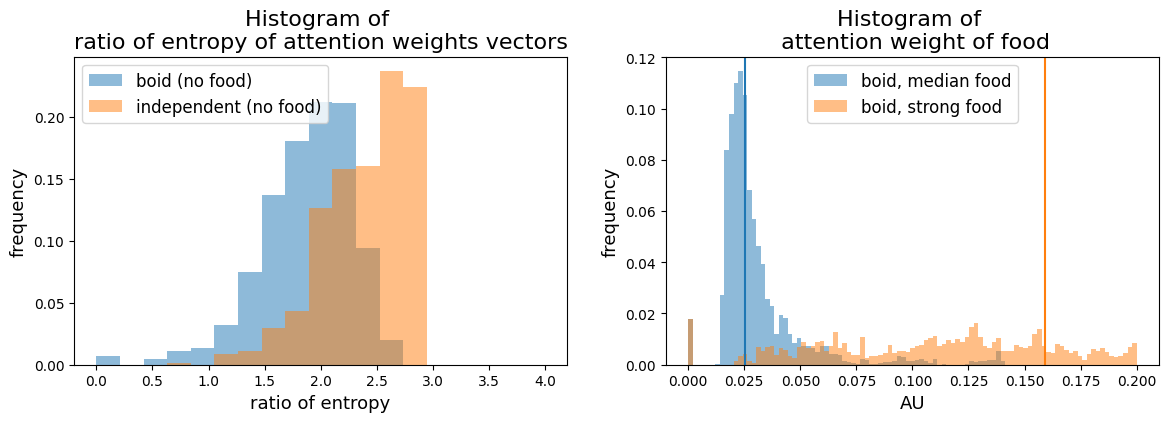

In [143]:
fig, axes = plt.subplots(1, 2, figsize = (14, 4))

axes[0].hist(entropy_1, bins = np.linspace(0,4,20),alpha = 0.5,
             weights = np.ones_like(entropy_1)/len(entropy_1), label = "boid (no food)")
axes[0].hist(entropy_2, bins = np.linspace(0,4,20),alpha = 0.5,
             weights = np.ones_like(entropy_2)/len(entropy_2), label = "independent (no food)")

#axes[0].hist(entropy_ratio_all_34, bins = np.linspace(0,2,20),alpha = 0.5,
#             weights = np.ones_like(entropy_ratio_all_34)/len(entropy_ratio_all_34),  label = "with food: boid/indep")
axes[0].set_title("Histogram of \nratio of entropy of attention weights vectors", fontsize = 16)

axes[1].hist(sum_food_3, alpha = 0.5,
             weights = np.ones_like(sum_food_3)/len(sum_food_3),
             bins = np.linspace(0, 0.2, 100), label = "boid, median food")
axes[1].hist(sum_food_4, alpha = 0.5,
             weights = np.ones_like(sum_food_4)/len(sum_food_4),
             bins = np.linspace(0, 0.2, 100), label = "boid, strong food")
axes[1].axvline(np.median(sum_food_3),color = 'C0')
axes[1].axvline(np.median(sum_food_4),color = 'C1')

axes[1].set_title("Histogram of \n attention weight of food", fontsize = 16)

"""
axes[2].hist(sum_food_3, alpha = 0.5,
             weights = np.ones_like(sum_food_3)/len(sum_food_3), bins = np.linspace(0,0.01,10), label = "boid with food")
axes[2].hist(sum_food_4, alpha = 0.5,
             weights = np.ones_like(sum_food_4)/len(sum_food_4), bins = np.linspace(0,0.01,10), label = "indep with food")
axes[2].set_title("Histogram of \n  attention weights of food")
"""

axes[0].set_xlabel("ratio of entropy", fontsize = 13)
axes[0].set_ylabel("frequency", fontsize = 13)
axes[1].set_xlabel("AU", fontsize = 13)
axes[1].set_ylabel("frequency", fontsize = 13)
axes[0].legend(fontsize = 12)
axes[1].legend(fontsize = 12)
#axes[2].legend()